# F - End-to-End ML Part 5: Gradient Boosting mit PCA + Model Comparison

Environment für dieses Notebook: `ads-ml-full` (*requirements-py3.11-ads-ml-full.txt*).


## Daten einlesen

In [1]:
from repml.datasets.trees_ber import prepare_trees_ber

data, labeled, unlabeled = prepare_trees_ber()

In [2]:
from sklearn import set_config

set_config(transform_output="pandas")

## Trainings- und Testdaten

In [3]:
from sklearn.model_selection import train_test_split

y = "pflanzjahr"
X = labeled.columns.to_list()
X.remove(y)
train_data, test_data = train_test_split(
    labeled, test_size=0.2, random_state=42, stratify=labeled["gattung_deutsch"]
)

## Features

In [4]:
num_cols_5 = [
    "kronedurch",
    "stammumfg",
    "baumhoehe",
    "hoehe_zu_krone",
    "hoehe_zu_stamm",
]

cat_cols_5 = [
    "bezirk",
    "baumart",
    "art_dtsch",
    "art_bot",
    "gattung_deutsch",
    "gattung",
    "art_dtsch_infrequent",
    "art_bot_infrequent",
    "gattung_deutsch_infrequent",
    "gattung_infrequent",
    "namenr",
    "namenr_nonum",
    "lon_section",
    "lat_section",
]
cols_set_5 = num_cols_5 + cat_cols_5

## Pipeline (exkl. PCA)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

ct_5a = ColumnTransformer(
    transformers=[
        ("imp", IterativeImputer(random_state=42), num_cols_5),
    ],
    remainder="passthrough",
)

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

ct_5b = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), ["imp__" + c for c in num_cols_5]),
        (
            "ohe",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            ["remainder__" + c for c in cat_cols_5],
        ),
    ],
)

In [7]:
from sklearn.pipeline import Pipeline

prep_5 = Pipeline(
    steps=[
        ("prep_a", ct_5a),
        ("prep_b", ct_5b),
    ]
)

## Pipeline PCA Step

### Wie viele Komponenten?

Dimension vorher (R,C): (220307, 19)
Dimension nach der Transformation (R,C): (220307, 6124)
Cumulative sum of explained variance: [0.18598821 0.29368563 0.35065131 0.3919458  0.43134198 0.46175915
 0.48873372 0.51246896 0.53366387 0.55422476 0.57216783 0.58907476
 0.60468245 0.62006199 0.63403669 0.6474058  0.65915355 0.67003298
 0.6802697  0.68974887 0.6980952  0.70614062 0.71394765 0.72121995
 0.72798286 0.73445976 0.74055925 0.74637744 0.75174405 0.7567362
 0.76132485 0.76567228 0.76986866 0.77392983 0.7778853  0.78173728
 0.78550546 0.78917115 0.79264911 0.79612039 0.79936114 0.80253097
 0.80556557 0.80821915 0.81075726 0.81295144 0.81510356 0.81714591
 0.81917588 0.8211625  0.82299557 0.82476614 0.82641607 0.82801778
 0.82960571 0.8311195  0.83258241 0.83402013 0.8353041  0.83654489
 0.83773709 0.83890435 0.84005342 0.84118903 0.84229838 0.84339193
 0.84446403 0.84551078 0.8465225  0.84751444 0.84848243 0.84944111
 0.85036275 0.85127365 0.85217227 0.85306146 0.85392867 0.8547743


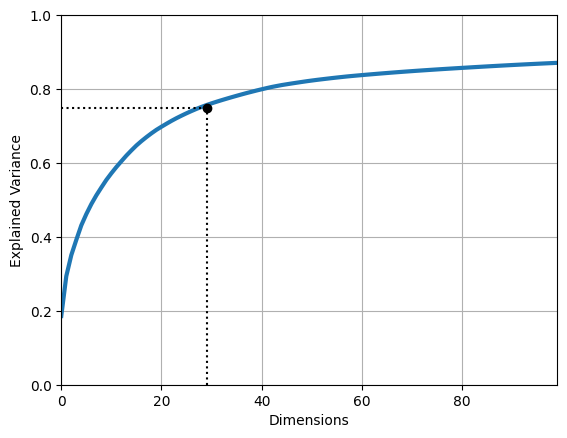

In [8]:
from repml.exploration.pca import check_for_components

variance = 0.75
components = check_for_components(
    max_components=100, data=train_data[cols_set_5], prep_pipeline=prep_5, variance=variance
)

## Versuch 5: Schlankere Feature Matrix mit PCA

In [9]:
from sklearn.decomposition import PCA

full_prep_5 = Pipeline(
    [("preprocessing", prep_5), ("ct_pca", PCA(n_components=components, random_state=42))]
)

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

est_5 = GradientBoostingRegressor(random_state=42, subsample=0.6, min_samples_split=100)

In [11]:
pipeline_5 = Pipeline(steps=[("prep", full_prep_5), ("model", est_5)])

In [12]:
import os

import mlflow
from dotenv import load_dotenv

load_dotenv()

mlflow.set_tracking_uri(os.getenv("LOCAL_MLFLOW_TRACKING_URI"))  # "sqlite:///mlflow.db"
mlflow.set_experiment("4F-e2e-part5")
mlflow.sklearn.autolog(log_models=False, log_datasets=False, silent=True)

In [13]:
%%time
pipeline_5.fit(train_data[cols_set_5], train_data[y])

CPU times: user 19min 36s, sys: 11min, total: 30min 37s
Wall time: 25min 21s


Pipeline(steps=[('prep',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('prep_a',
                                                   ColumnTransformer(remainder='passthrough',
                                                                     transformers=[('imp',
                                                                                    IterativeImputer(random_state=42),
                                                                                    ['kronedurch',
                                                                                     'stammumfg',
                                                                                     'baumhoehe',
                                                                                     'hoehe_zu_krone',
                                                                                     'hoehe_zu_stamm'])])),
                                                  ('prep_b',
                                                   ColumnTransformer(transformers=[('scale',
                                                                                    StandardScaler(),
                                                                                    ['imp__kronedurch',
                                                                                     'imp__...
                                                                                     'remainder__art_dtsch_infrequent',
                                                                                     'remainder__art_bot_infrequent',
                                                                                     'remainder__gattung_deutsch_infrequent',
                                                                                     'remainder__gattung_infrequent',
                                                                                     'remainder__namenr',
                                                                                     'remainder__namenr_nonum',
                                                                                     'remainder__lon_section',
                                                                                     'remainder__lat_section'])]))])),
                                 ('ct_pca',
                                  PCA(n_components=29, random_state=42))])),
                ('model',
                 GradientBoostingRegressor(min_samples_split=100,
                                           random_state=42, subsample=0.6))])

## Performance
### R-squared (Bestimmtheitsmaß)

In [14]:
%%time
from sklearn.model_selection import cross_val_score

transformed_5 = pipeline_5[:-1].transform(train_data[cols_set_5])

cross_val_score(estimator=pipeline_5[-1], X=transformed_5, y=train_data[y], cv=3, n_jobs=3)

CPU times: user 2min 18s, sys: 1min 44s, total: 4min 2s
Wall time: 9min 51s


array([0.74008452, 0.73547184, 0.7365739 ])

In [15]:
from sklearn.metrics import r2_score

r2_score(y_true=test_data[y], y_pred=pipeline_5.predict(test_data[X]))

0.7343333083525672

R-squared ist die Default Metrik für den Estimator.

In [16]:
pipeline_5.score(X=test_data[X], y=test_data[y])

0.7343333083525672

### Mean Absolute Error

In [17]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=test_data[y], y_pred=pipeline_5.predict(test_data[X]))

10.21690112718138

### Root Mean Squared Error

Scikit-learn implementiert nur den MSE, davon nehmen wir die Wurzel.

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_true=test_data[y], y_pred=pipeline_5.predict(test_data[X])))

15.107517302373514

## Explainability?

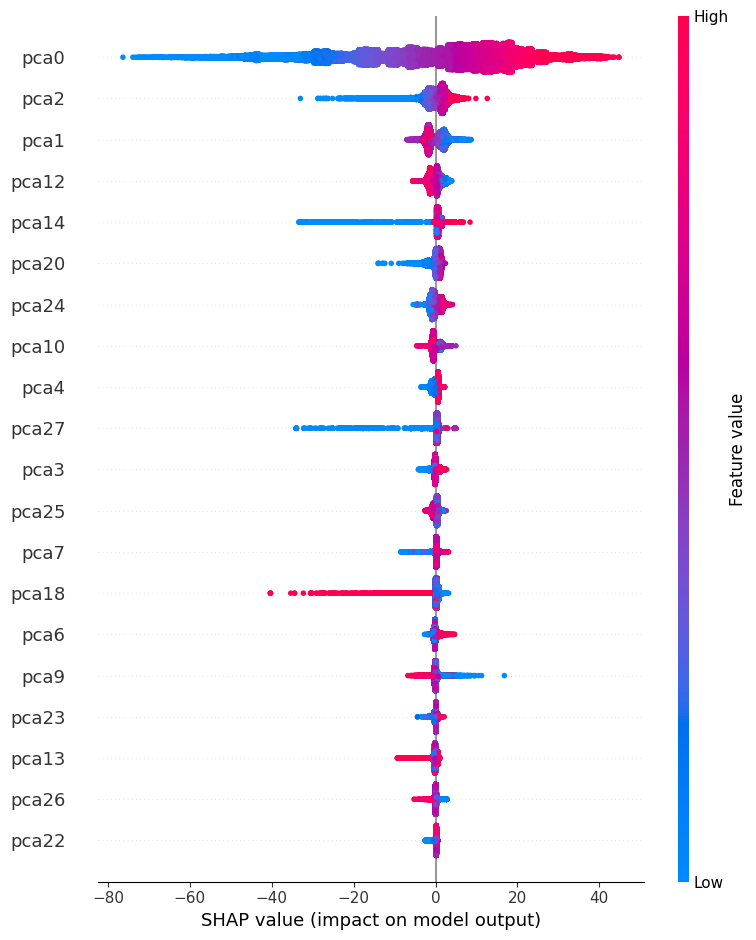

In [20]:
import shap

transformed_test_5 = pipeline_5[:-1].transform(test_data[cols_set_5])

explainer_5 = shap.TreeExplainer(pipeline_5.named_steps["model"])
shap_values_test_5 = explainer_5.shap_values(transformed_test_5)
shap.summary_plot(
    shap_values=shap_values_test_5,
    features=transformed_test_5,
    feature_names=pipeline_5[:-1].get_feature_names_out(),
)

## Model Comparison

In [21]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lars, BayesianRidge
from sklearn.neural_network import MLPRegressor

In [22]:
models = [
    ("LinearRegression", LinearRegression()),
    ("Lars", Lars(random_state=42)),
    ("ElasticNet", ElasticNet(random_state=42)),
    ("BayesianRidge", BayesianRidge()),
    ("MLPregressor", MLPRegressor(hidden_layer_sizes=(30, 30), random_state=42)),
]

In [23]:
%%time
from sklearn.model_selection import cross_val_score

for model in models:
    pipeline = Pipeline(steps=[("prep", full_prep_5), (model[0], model[1])])
    pipeline.fit(X=train_data[cols_set_5], y=train_data[y])
    cv = cross_val_score(
        estimator=pipeline[-1],
        X=pipeline[:-1].transform(train_data[cols_set_5]),
        y=train_data[y],
        cv=3,
        n_jobs=3,
    )
    print("\nEVALUATING", model[0])
    print("Cross validation", cv)
    print("Performance on test data")
    print("R2:", pipeline.score(X=test_data[cols_set_5], y=test_data[y]))
    print("MAE:", mean_absolute_error(y_true=test_data[y], y_pred=pipeline.predict(test_data[X])))


EVALUATING LinearRegression
Cross validation [0.63699628 0.63838353 0.63813719]
Performance on test data
R2: 0.6345870171155061
MAE: 11.869430729356633

EVALUATING Lars
Cross validation [0.63699628 0.63838353 0.63813719]
Performance on test data
R2: 0.6345870171155062
MAE: 11.869430729356628

EVALUATING ElasticNet
Cross validation [0.5490896  0.55461336 0.54719513]
Performance on test data
R2: 0.5447704971844273
MAE: 13.164881159223532

EVALUATING BayesianRidge
Cross validation [0.63699548 0.63838794 0.63813462]
Performance on test data
R2: 0.6345868900963747
MAE: 11.869133158448228

EVALUATING MLPregressor
Cross validation [0.74660834 0.74292776 0.74378622]
Performance on test data
R2: 0.2798893056544136
MAE: 10.312893274704637
CPU times: user 44min 16s, sys: 31min 25s, total: 1h 15min 42s
Wall time: 47min 53s
